In [11]:
import re
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt

В данном исследование я буду использовать датасет содержащий информацию о наибольшей стоимости криптовалюты
биткоин за каждый день в промежутке с 2015-11-12 по 2018-09-27. Датасет взят с платформы kaggle 
https://www.kaggle.com/taniaj/cryptocurrency-market-history-coinmarketcap#all_currencies.csv

In [76]:
data = pd.read_csv('all_currencies.csv')
data = data[(data.Symbol == 'BIT')]
print("Size: ", len(data))
data[:10]

Size:  789


,Unnamed: 0,Date,Symbol,Open,High,Low,Close,Volume,Market Cap
59775,0,2016-07-25,BIT,0.000590,0.000591,0.000588,0.000589,186.0,NaN
59776,1,2016-07-26,BIT,0.000589,0.000590,0.000581,0.000590,2.0,NaN
59777,2,2016-07-27,BIT,0.000390,0.000394,0.000389,0.000393,2.0,NaN
59778,3,2016-07-28,BIT,0.000393,0.000394,0.000393,0.000394,2.0,NaN
59779,4,2016-07-30,BIT,0.000401,0.000685,0.000401,0.000681,9.0,NaN
59780,5,2016-07-31,BIT,0.000681,0.000681,0.000150,0.000150,7.0,NaN
59781,6,2016-08-01,BIT,0.000150,0.000150,0.000062,0.000073,19.0,NaN
59782,7,2016-08-02,BIT,0.000073,0.001009,0.000069,0.000958,3870.0,NaN
59783,8,2016-08-03,BIT,0.000960,0.000960,0.000087,0.000090,3962.0,NaN
59784,9,2016-08-06,BIT,0.000251,0.000259,0.000251,0.000259,0.0,NaN


Рассматриваться будет небезызвестная криптовалюта BITCOIN на временном промежутке (25.07.2016 - 27.09.2018)

В качестве данных для анализ будет взята максимальная стоимость биткоина (колонка High). Все данные кроме даты можно удалить.

Цели исследования:
1. Проверка существования сезонности в изменении стоимости криптовалюты
2. Попытаться предсказать стоимость криптовалюты в будущем

In [3]:
data['dt'] = pd.to_datetime(data.Date, format="%Y-%m")
data.index = data.dt

In [4]:
class Data():
    
    def __init__(self, currence_type):
        self.crypto = currence_type
    
    def extract_mean(self, column='High', periods='Year'):
        
        coin_list = np.array(list(data[data.Symbol == self.crypto][column]))
        date_list = np.array(list(data[data.Symbol == self.crypto]['Date']))
        all_date_list = np.array(data['Date'])
        
        if periods == 'Year':
            year_list = [int(re.split('-', date)[0]) for date in all_date_list]
            data['Year'] = year_list
            self.year_list_u = np.unique(year_list)
            self.mean_year = np.zeros(self.year_list_u.shape[0])
            for year in self.year_list_u:
                self.mean_year[year-self.year_list_u[0]] = np.mean(np.array( \
                    data[(data.Symbol == self.crypto) & (data.Year == year)][column]  ))
        
        if periods == 'Month':
            self.month_list = [int(re.split('-', date)[1]) for date in all_date_list]
            tmp_list = np.zeros(len(all_date_list))
            tmp = 1
            prev = self.month_list[0]
           
            for j in range(len(all_date_list)):
                if self.month_list[j] == prev:
                    tmp_list[j] = int(tmp)
                else:
                    tmp += 1
                    tmp_list[j] == int(tmp)
                prev = self.month_list[j]
                    
            pass  
            data['MP'] = tmp_list
            self.month_count = np.unique(tmp_list)
            self.mean_month = np.zeros(self.month_count.shape[0])
            for m in self.month_count:
                self.mean_month[int(m)] = np.mean(np.array(
                    data[(data.Symbol == self.crypto) & (data.MP == m)][column]))
        
        if periods == 'Day':
            self.mean_day = data['High']
            self.day_x = np.arange(0, len(all_date_list))
            
        pass

In [5]:
bitcoin = Data('BIT')
bitcoin.extract_mean('High', 'Year')
bitcoin.extract_mean('High', 'Month')
bitcoin.extract_mean('High', 'Day')

Text(0.5, 1.0, 'Bitcoin day high price dynamics')

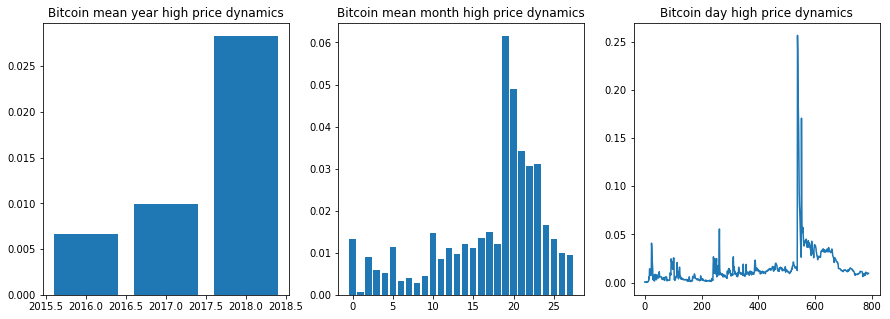

In [6]:
fig, axes = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)

axes[0].bar(bitcoin.year_list_u, bitcoin.mean_year)
axes[0].set_title('Bitcoin mean year high price dynamics')
axes[1].bar(bitcoin.month_count, bitcoin.mean_month)
axes[1].set_title('Bitcoin mean month high price dynamics')
axes[2].plot(bitcoin.day_x, bitcoin.mean_day)
axes[2].set_title('Bitcoin day high price dynamics')

Из графиков видно, что в феврале 2018 произошёл резкий рост стоимости криптовалюты,
поэтому по факту для поиска тенденции в изменении стоимости стоит учитывать только 
данные начиная с марта 2018

Text(0.5, 1.0, 'Bitcoin day high price dynamics since Mart 2018')

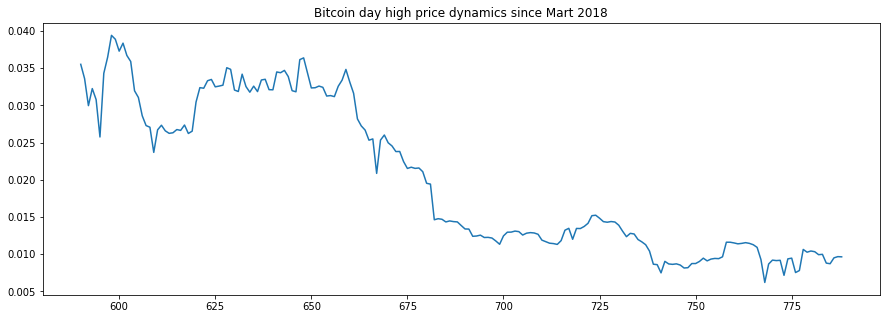

In [7]:
fig, axes = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(15)
axes.plot(bitcoin.day_x[590:], bitcoin.mean_day[590:])
axes.set_title('Bitcoin day high price dynamics since Mart 2018')

In [8]:
df = pd.DataFrame(data['High'][590:]).dropna()

C:\Users\andre\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


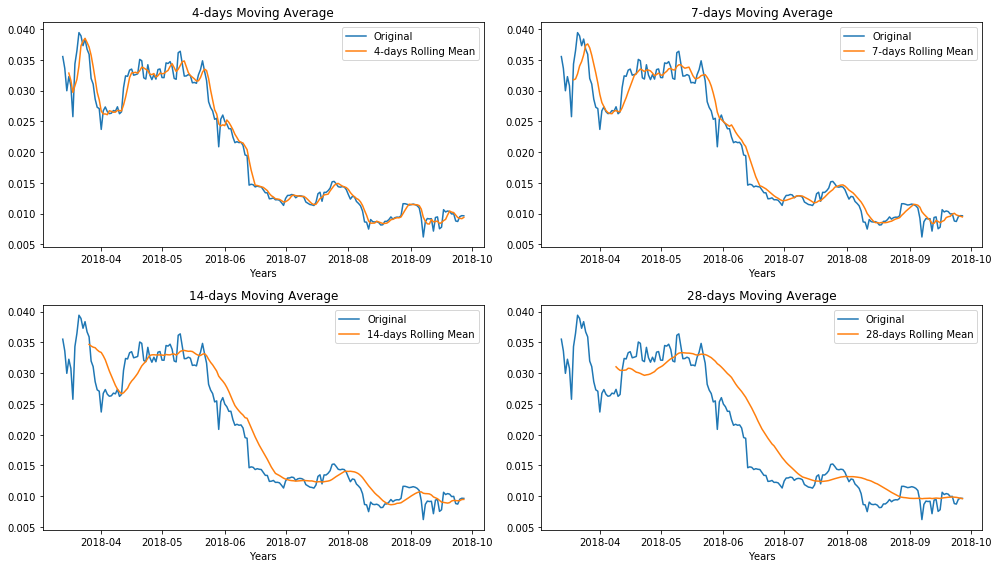

In [9]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(df.High, label='Original')
axes[0][0].plot(df[3:].index, df.rolling(window=4).mean()[3:], label='4-days Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_title("4-days Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(df.High, label='Original')
axes[0][1].plot(df[3:].index, df.rolling(window=7).mean()[3:], label='7-days Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_title("7-days Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(df.High, label='Original')
axes[1][0].plot(df[3:].index, df.rolling(window=14).mean()[3:], label='14-days Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_title("14-days Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(df.High, label='Original')
axes[1][1].plot(df[3:].index, df.rolling(window=28).mean()[3:], label='28-days Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_title("28-days Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

Рассмотрим тренд с помощью скользящего среднего. 

1      - достаточно неплохо отображает тенденции на всех участках графика, 
избегая непродолжительных скачков в значениях.

3, 4   - полностью нивелируют все резкие изменения и отображают основную тенденцию

2      - на первый взгляд лучше всего показывает основной тренд

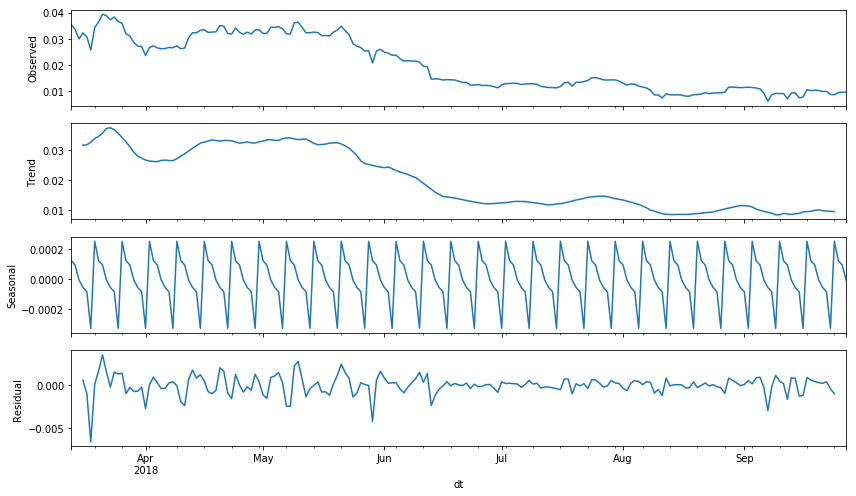

In [13]:
rcParams['figure.figsize'] = 12, 7
sm.tsa.seasonal_decompose(df.High).plot()
plt.show()

По этим графикам оценим составные части

1.Тренд - колеблется от 0.00 до 0.04 
  
  Полученный график хорошо показывает постепенное уменьшение стоимости биткоина 

2.Сезонность - как видно из графика сезонности в изменении стоимости не наблюдается (0.0002 << 0.04)

3.Шум - из графика видно, что внутри шума нет никакого тренда, лишь колебания в окрестности нуля.

In [48]:
train_data = df.sort_values('dt', ascending = True).iloc[:-18]
test_data = df.sort_values('dt', ascending = True).iloc[-18:]

In [49]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.05):

    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

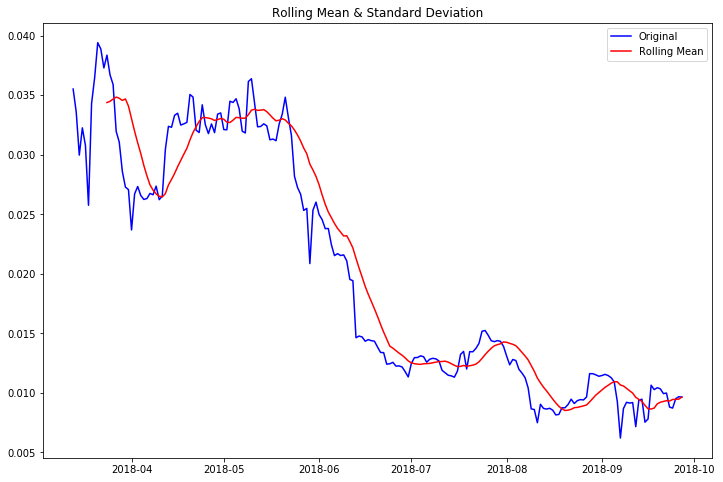

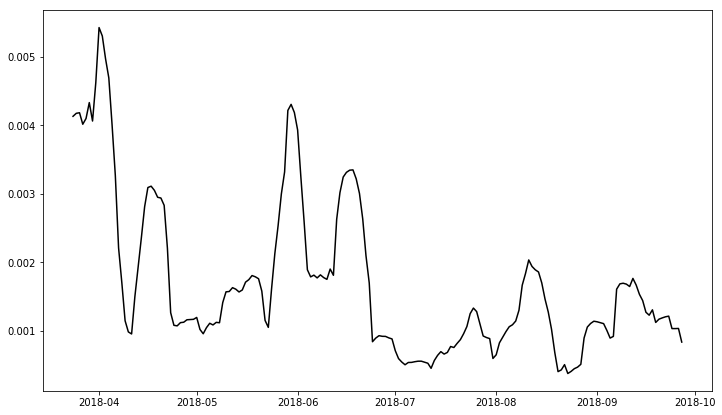

Results of Dickey-Fuller Test:
p-value = 0.6037. The series is likely non-stationary.
Test Statistic                  -1.354962
p-value                          0.603667
#Lags Used                       0.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64


In [50]:
test_stationarity(df.High)

Попробуем прологарифмировать

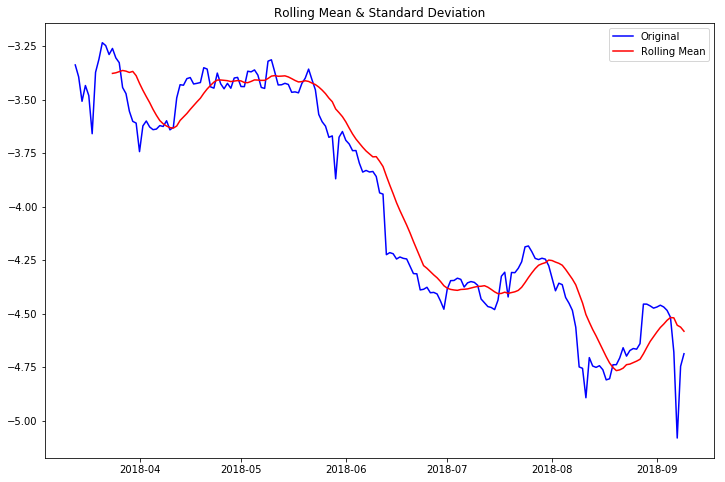

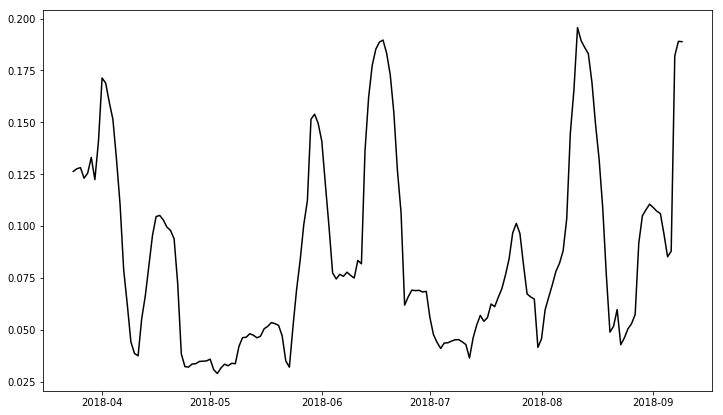

Results of Dickey-Fuller Test:
p-value = 0.7838. The series is likely non-stationary.
Test Statistic                  -0.912534
p-value                          0.783817
#Lags Used                       0.000000
Number of Observations Used    180.000000
Critical Value (1%)             -3.467211
Critical Value (5%)             -2.877735
Critical Value (10%)            -2.575403
dtype: float64


In [51]:
train_data['log'] = np.log(train_data.High)
train_data.dropna(inplace = True)
test_stationarity(train_data['log'], window = 12)

После логарифмирования видно, что rolling mean стал лучше апроксимировать исходную функцию

Теперь попробуем продифференцировать


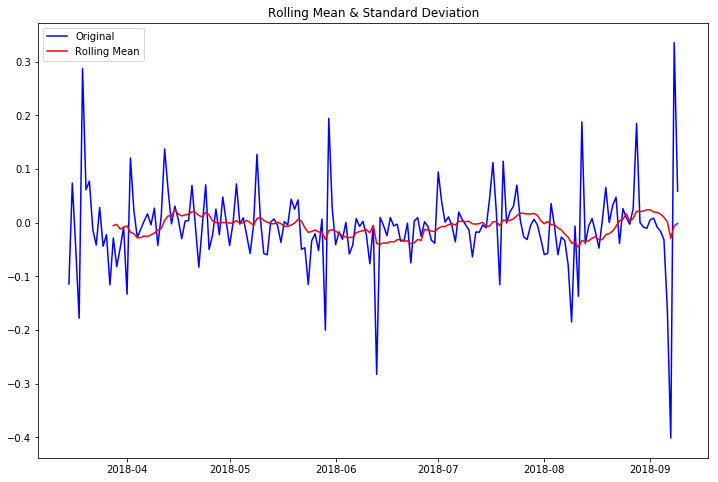

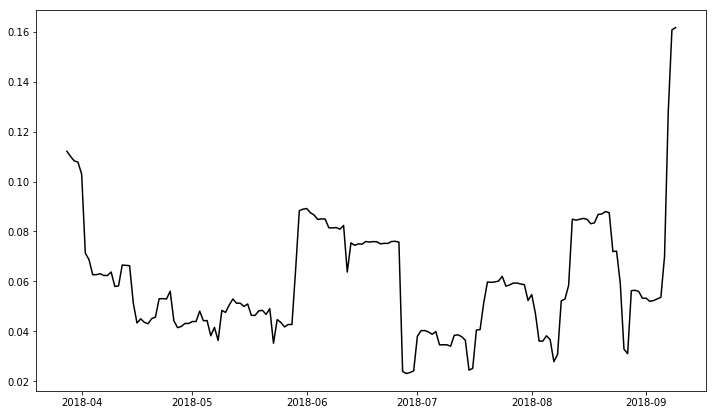

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.470741e+01
p-value                        2.882808e-27
#Lags Used                     0.000000e+00
Number of Observations Used    1.780000e+02
Critical Value (1%)           -3.467632e+00
Critical Value (5%)           -2.877918e+00
Critical Value (10%)          -2.575501e+00
dtype: float64


In [75]:
train_data['log_diff'] = train_data.log - train_data.log.shift(1)
train_data.dropna(inplace = True)
test_stationarity(train_data['log_diff'], window = 14)

Дифференцирование позволяет хорошо апроксимировать исходные данные, при этом
избегая локльных выбросов. Это хорошо видно из графика.

Теперь проверим статистические гипотезы:

H0 - среднее значение за 28 дней после марта 2018 года не изменилось

Используем критерий Стьюдента для первой выборки со всеми последующими и возьмём их среднее:

Из графика для скользящего окна размером 28-дней видно, что с распределение значений близко к нормальному

Следовательно критерий Стьюдента применим

То есть оценим отношение разности средних значений относительно самих средних:


In [101]:
part = train_data['High'][:28].mean()
parts = []
for i in range(1, int(train_data.shape[0] / 28 - 1)):
    parts.append(train_data['High'][28 * i:28 * (i + 1)].mean())

In [102]:
s = 0
for p in range(len(parts)):
    s += abs((part - parts[p]) / (part + parts[p]))
krit = s / len(parts)
krit

0.20196310216530328

0.2 >> 0.04

Получаем что отклонение среднего сильно превышает дисперсию значений,

что означает, что гипотеза H0 - неверна. 

Проверим другую гипотезу:

H0 - средняя стоимость биткоина после марта 2018 равна 0.02

используем одновыборочный критерий

In [98]:
(len(train_data[train_data.High > 0.02]) - len(train_data[train_data.High < 0.02])) / 2

-1.5

M = -1.5 очень хороший показатель

Гипотеза H0 - принимается

Для предсказания временного ряда попробуем использовать модель SARIMA 

In [61]:
"""
параметры для модели
"""
d = 1
D = 0
s = 12

ps = range(0, 5)
d=1
qs = range(0, 5)
Ps = range(0, 5)
D=0
Qs = range(0, 5)

In [62]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [69]:
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_data.log, order=(param[0], d, param[1]), 
                                         seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [70]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                log   No. Observations:                  180
Model:             SARIMAX(0, 1, 0)x(2, 0, 2, 12)   Log Likelihood                 214.052
Date:                            Mon, 13 May 2019   AIC                           -418.104
Time:                                    16:08:37   BIC                           -402.168
Sample:                                03-14-2018   HQIC                          -411.642
                                     - 09-09-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.2354      0.237     -5.215      0.000      -1.700      -0.771
ar.S.L24      -0.8047      0.181   

In [72]:
forecast = best_model.predict(start = train_data.shape[0], end = train_data.shape[0] + test_data.shape[0])

C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


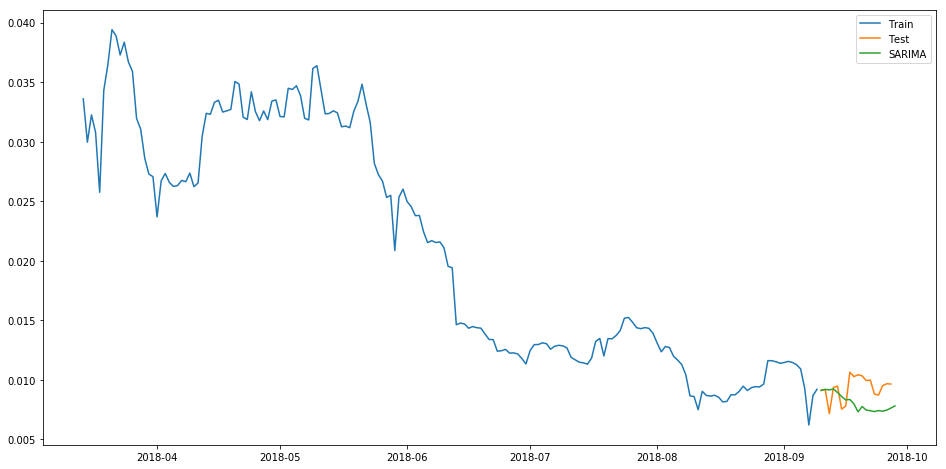

In [73]:
plt.figure(figsize=(16,8))
plt.plot(train_data.High, label='Train')
plt.plot(test_data.High, label='Test')
plt.plot(np.exp(forecast), label='SARIMA')
plt.legend(loc='best')
plt.show()

Проанализируем полученное предсказание:

Видно, что predict строит линию хорошо отражающую тренд на замедляющееся снижение стоимости.

Из-за сложности исходных данных в последнем периоде случился внезапный рост стоимости, который 

в данном случае является шумом.   Поскольку биткоин является криптовалютой, рост и снижение его 

стоимости практически не имеют ограничений,  что в значительной степени усложняет предсказание. 

Тем не менее использование скользящего окна позволяет отличить аномалии в виде естественых 

скачков стоимости криптовалюты от основных тенденций  в стоимости. Так же логарифмирование и 

дифференцирование позволяет полностью нивелировать  все аномалии в данных. Основываясь лишь на моих 

предположениях стоимость криптовалюты в значительной мере определяется популярностью. В таком случае 

после резкого роста стоимости в феврале 2018 можно предположить, что замедление уменьшения стоимости 

обосновывается тем, что криптовалюта начинает в большей степени использоваться теми пользователями,

которые теснее связаны с конкретной криптовалютой (например родом деятельности) и в меньшей степени

теми, кто пользовался ей просто по причине её популярности. Из этого предположения SARIMA хорошо отражает 

описанный тренд на замедление снижения стоимости.